In [4]:
# %% [markdown]
# # Sentiment Analysis with RoBERTa Transformer
# Using Twitter-trained RoBERTa model for EA Forum Posts

# %%
# Install required packages (run once)
# !pip install pandas transformers torch accelerate matplotlib seaborn wordcloud tqdm

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import torch
from transformers import pipeline
import warnings
warnings.filterwarnings('ignore')

# Check if GPU is available
device = 0 if torch.cuda.is_available() else -1
print(f"Using: {'GPU 🚀' if device == 0 else 'CPU'}")

# %%
# Load the data
df = pd.read_csv('ea_forum_posts.csv')
print(f"Loaded {len(df)} posts")

# Combine title and body for better context
df['full_text'] = df['title'].fillna('') + '. ' + df['body_preview'].fillna('')
df['full_text'] = df['full_text'].str.strip()

df.head()

# %% [markdown]
# ## RoBERTa Model
# Using Cardiff NLP's RoBERTa trained on Twitter data - excellent for informal text and forums

# %%
# Initialize RoBERTa sentiment analysis pipeline
print("Loading RoBERTa model (this may take a minute)...")

sentiment_roberta = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment-latest",
    device=device,
    truncation=True,
    max_length=512
)

print("✅ RoBERTa model loaded!")

# %%
# Function to safely analyze sentiment with error handling
def analyze_sentiment(text, analyzer):
    """Analyze sentiment with error handling for long/problematic texts"""
    if pd.isna(text) or not text.strip():
        return {'label': 'neutral', 'score': 0.0}
    
    try:
        # Truncate very long texts
        text = str(text)[:1500]
        result = analyzer(text)[0]
        return result
    except Exception as e:
        print(f"Error analyzing text: {e}")
        return {'label': 'neutral', 'score': 0.0}

# %%
# Analyze with RoBERTa
print("Analyzing sentiment with RoBERTa...")
tqdm.pandas(desc="RoBERTa Analysis")

roberta_results = df['full_text'].progress_apply(
    lambda x: analyze_sentiment(x, sentiment_roberta)
)

df['roberta_label'] = roberta_results.apply(lambda x: x['label'])
df['roberta_score'] = roberta_results.apply(lambda x: x['score'])

# Map labels to standardized format
label_map_roberta = {
    'positive': 'Positive',
    'negative': 'Negative', 
    'neutral': 'Neutral'
}
df['sentiment'] = df['roberta_label'].map(label_map_roberta)
df['confidence'] = df['roberta_score']

# Create compound score (-1 to 1)
def calculate_compound(row):
    label = row['sentiment']
    score = row['confidence']
    if label == 'Positive':
        return score
    elif label == 'Negative':
        return -score
    return 0

df['compound_score'] = df.apply(calculate_compound, axis=1)

# %%
# Display Results Summary
print("=" * 60)
print("ROBERTA SENTIMENT ANALYSIS RESULTS")
print("=" * 60)

print(f"\n📊 Total Posts Analyzed: {len(df)}")

print("\n" + "-" * 40)
print("Sentiment Distribution:")
print("-" * 40)
print(df['sentiment'].value_counts())

print(f"\nPercentages:")
print(df['sentiment'].value_counts(normalize=True).mul(100).round(1))

print(f"\nAverage Compound Score: {df['compound_score'].mean():.3f}")
print(f"Average Confidence: {df['confidence'].mean():.3f}")




/Users/porkr/projects/ea_scraper/fc2026/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/porkr/projects/ea_scraper/fc2026/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Using: CPU
Loaded 1551 posts
Loading RoBERTa model (this may take a minute)...


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


✅ RoBERTa model loaded!
Analyzing sentiment with RoBERTa...


RoBERTa Analysis: 100%|█████████████████████| 1551/1551 [00:46<00:00, 33.27it/s]

ROBERTA SENTIMENT ANALYSIS RESULTS

📊 Total Posts Analyzed: 1551

----------------------------------------
Sentiment Distribution:
----------------------------------------
sentiment
Negative    1221
Neutral      280
Positive      50
Name: count, dtype: int64

Percentages:
sentiment
Negative    78.7
Neutral     18.1
Positive     3.2
Name: proportion, dtype: float64

Average Compound Score: -0.595
Average Confidence: 0.765


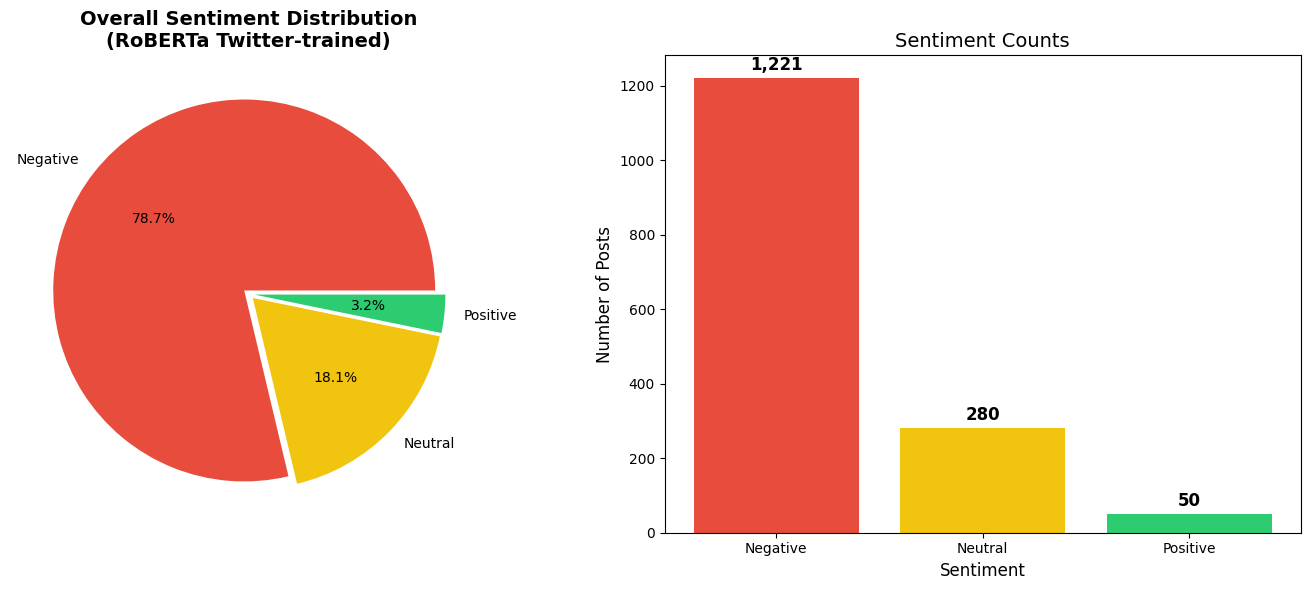

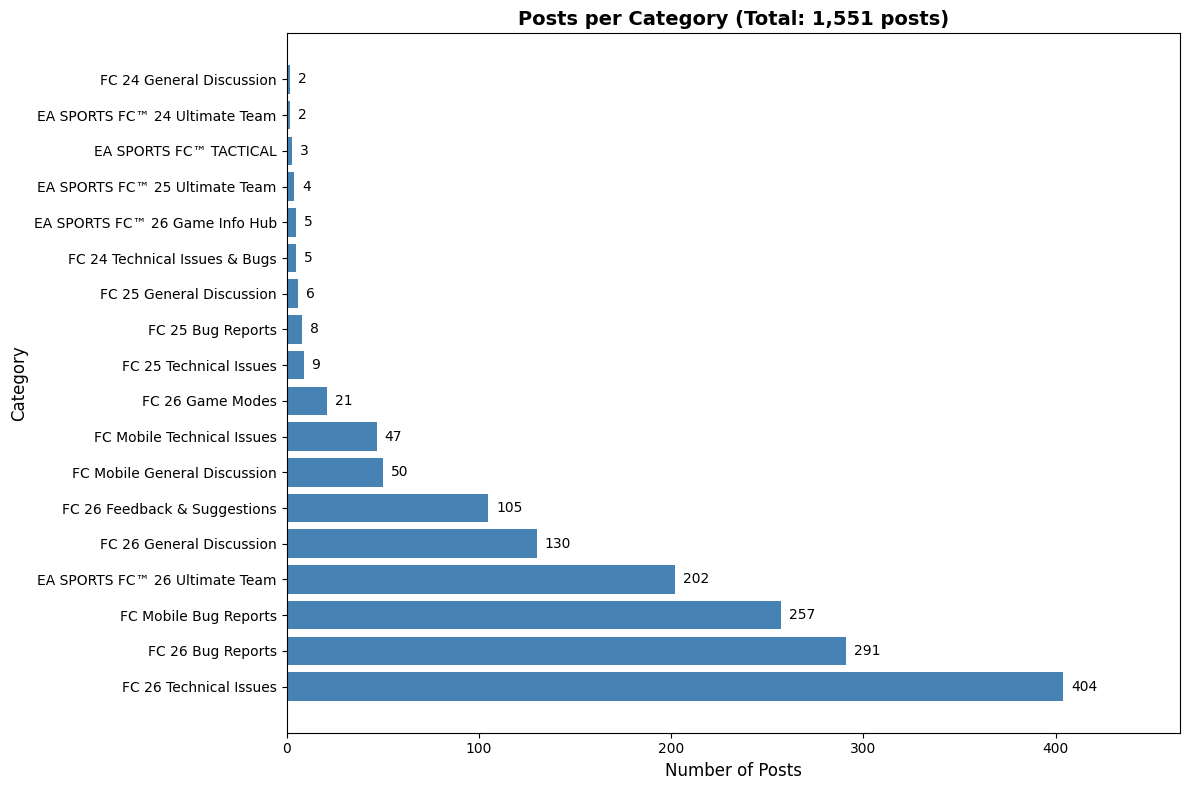


----------------------------------------
📊 POSTS PER CATEGORY:
----------------------------------------
  FC 26 Technical Issues: 404 posts (26.0%)
  FC 26 Bug Reports: 291 posts (18.8%)
  FC Mobile Bug Reports: 257 posts (16.6%)
  EA SPORTS FC™ 26 Ultimate Team: 202 posts (13.0%)
  FC 26 General Discussion: 130 posts (8.4%)
  FC 26 Feedback & Suggestions: 105 posts (6.8%)
  FC Mobile General Discussion: 50 posts (3.2%)
  FC Mobile Technical Issues: 47 posts (3.0%)
  FC 26 Game Modes: 21 posts (1.4%)
  FC 25 Technical Issues: 9 posts (0.6%)
  FC 25 Bug Reports: 8 posts (0.5%)
  FC 25 General Discussion: 6 posts (0.4%)
  FC 24 Technical Issues & Bugs: 5 posts (0.3%)
  EA SPORTS FC™ 26 Game Info Hub: 5 posts (0.3%)
  EA SPORTS FC™ 25 Ultimate Team: 4 posts (0.3%)
  EA SPORTS FC™ TACTICAL: 3 posts (0.2%)
  EA SPORTS FC™ 24 Ultimate Team: 2 posts (0.1%)
  FC 24 General Discussion: 2 posts (0.1%)


<Figure size 1400x800 with 0 Axes>

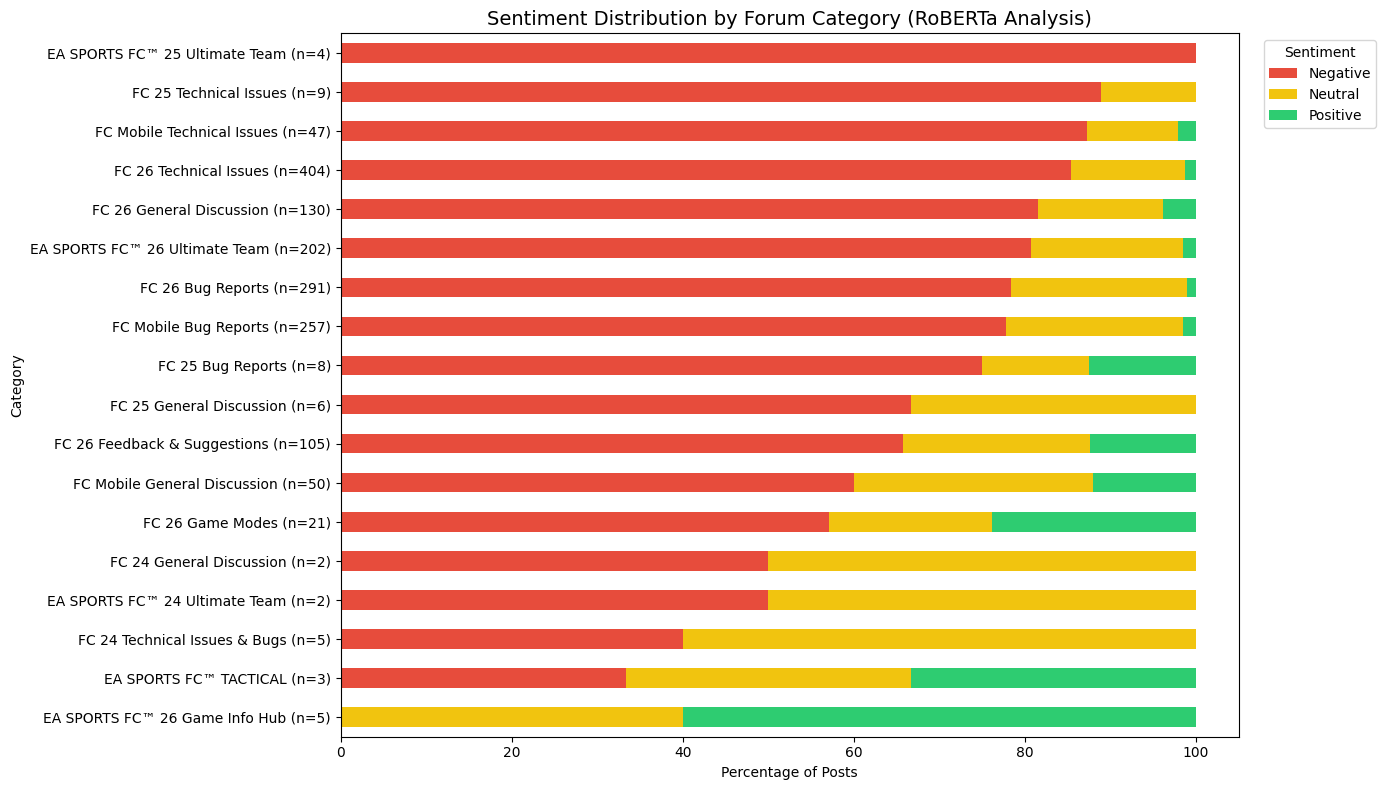

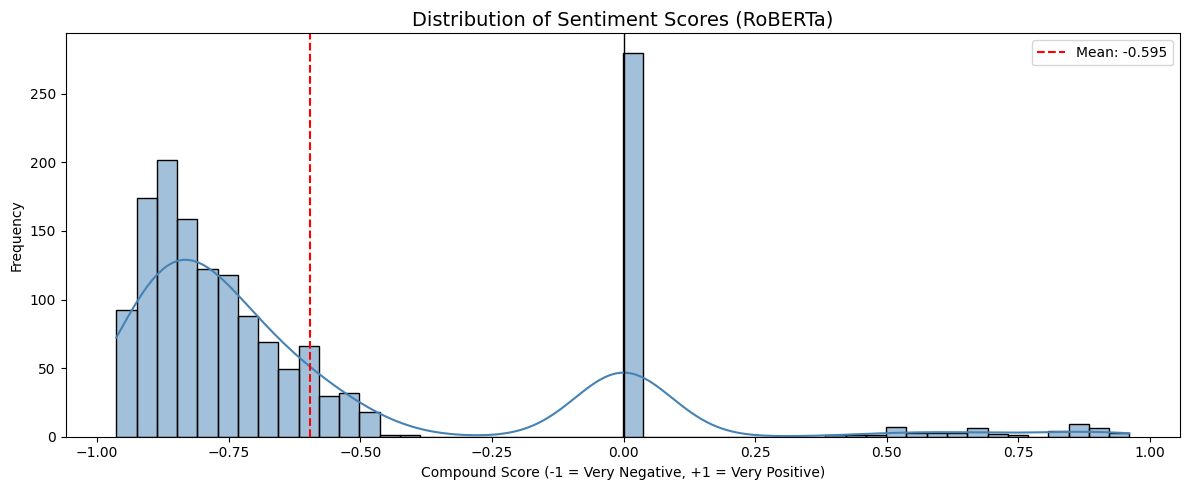

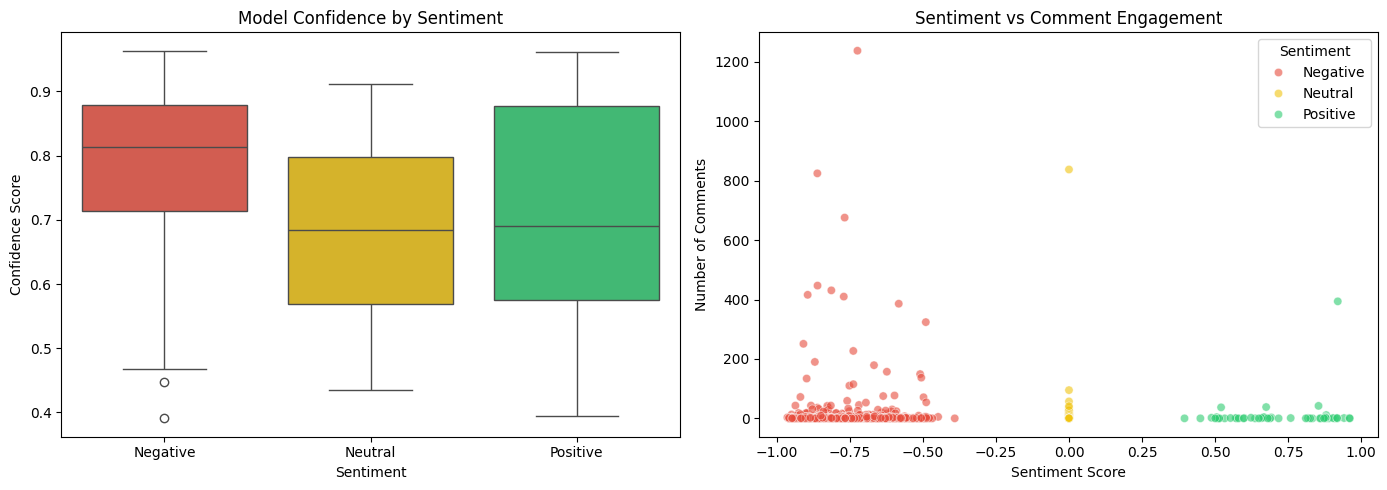


📈 CORRELATION ANALYSIS


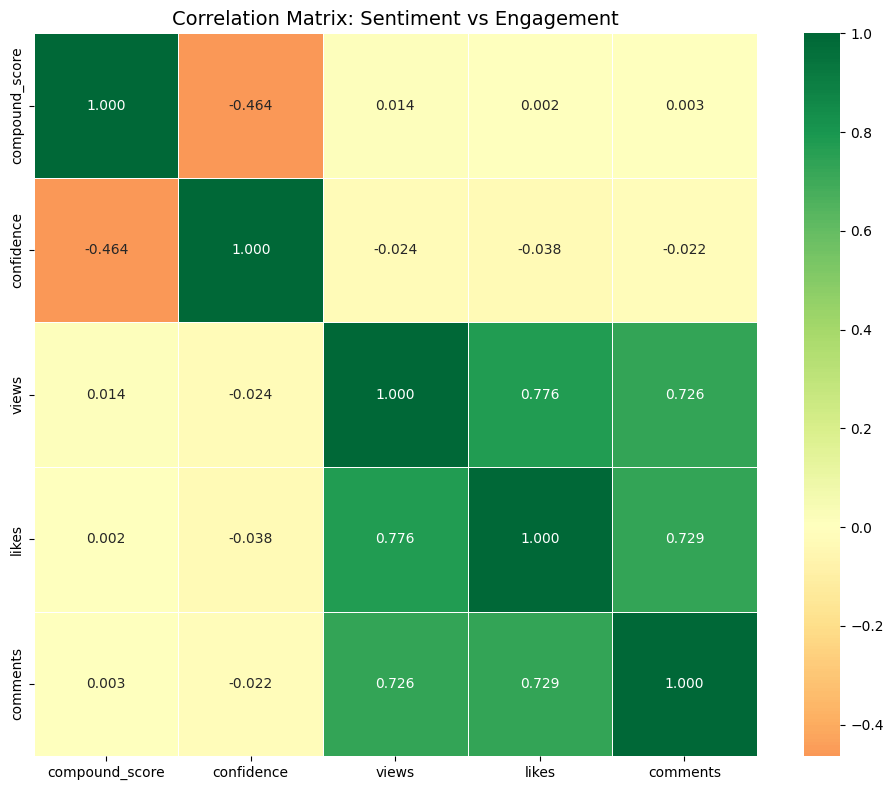

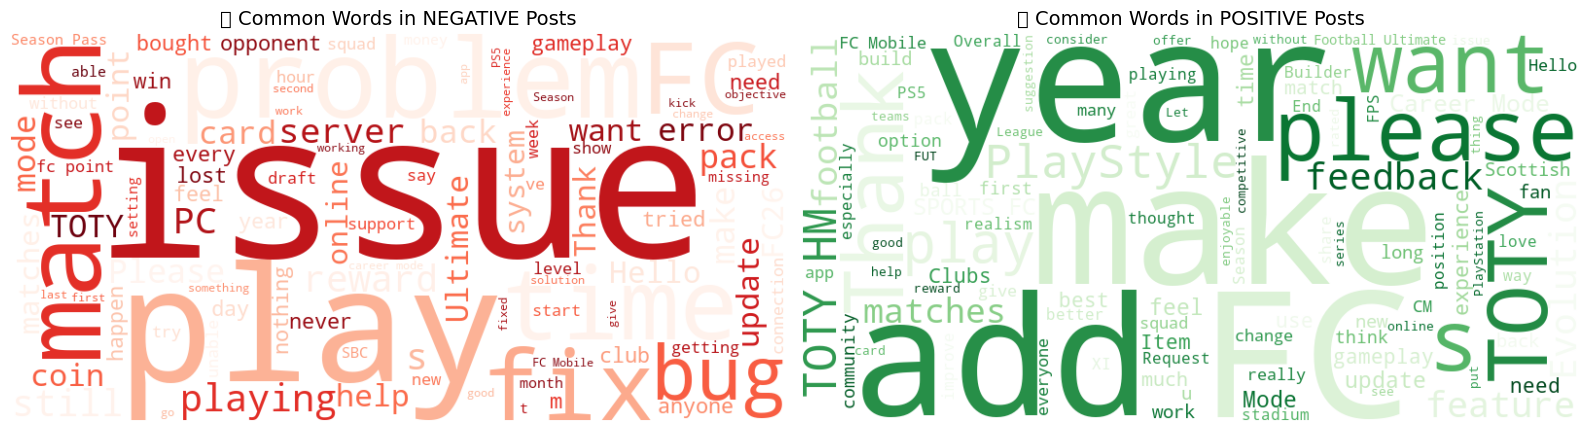

✅ Results exported to 'ea_forum_sentiment_roberta.csv'

📊 FINAL SENTIMENT ANALYSIS REPORT

📈 OVERVIEW
────────────────────────────────────────
Total Posts Analyzed: 1,551
Model: RoBERTa (Twitter-trained)
Average Sentiment Score: -0.595
Average Model Confidence: 0.765

📊 SENTIMENT BREAKDOWN
────────────────────────────────────────
🟢 Positive: 50 (3.2%)
🟡 Neutral:  280 (18.1%)
🔴 Negative: 1,221 (78.7%)

🎯 KEY INSIGHTS
────────────────────────────────────────
• Overall forum sentiment: NEGATIVE 😠
• Most discussed issues appear in negative posts
• High-engagement posts tend to be more negative

📁 FILES GENERATED
────────────────────────────────────────
• ea_forum_sentiment_roberta.csv (full results)
• sentiment_distribution.png
• posts_per_category.png
• sentiment_by_category.png
• compound_score_distribution.png
• confidence_and_engagement.png
• correlation_matrix.png
• wordclouds.png



In [18]:
# %%
# Visualization 1: Overall Sentiment Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

colors = {'Positive': '#2ecc71', 'Neutral': '#f1c40f', 'Negative': '#e74c3c'}

# Pie chart
ax1 = axes[0]
sentiment_counts = df['sentiment'].value_counts()
ax1.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%',
        colors=[colors.get(l, '#95a5a6') for l in sentiment_counts.index],
        explode=[0.03] * len(sentiment_counts))
ax1.set_title('Overall Sentiment Distribution\n(RoBERTa Twitter-trained)', fontsize=14, fontweight='bold')

# Bar chart with counts
ax2 = axes[1]
bars = ax2.bar(sentiment_counts.index, sentiment_counts.values,
               color=[colors.get(l, '#95a5a6') for l in sentiment_counts.index])
ax2.set_xlabel('Sentiment', fontsize=12)
ax2.set_ylabel('Number of Posts', fontsize=12)
ax2.set_title('Sentiment Counts', fontsize=14)

# Add count labels on bars
for bar, count in zip(bars, sentiment_counts.values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(sentiment_counts.values)*0.01,
             f'{count:,}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('sentiment_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# %%
# Visualization 2a: Category Post Counts
if 'category' in df.columns:
    plt.figure(figsize=(12, 8))
    
    # Get category counts and sort
    category_counts = df['category'].value_counts()
    
    # Create horizontal bar chart
    bars = plt.barh(range(len(category_counts)), category_counts.values, color='steelblue')
    plt.yticks(range(len(category_counts)), category_counts.index)
    
    # Add count labels on the bars
    for i, (count, bar) in enumerate(zip(category_counts.values, bars)):
        plt.text(count + max(category_counts.values) * 0.01, i, f'{count:,}', 
                 va='center', fontsize=10)
    
    plt.xlabel('Number of Posts', fontsize=12)
    plt.ylabel('Category', fontsize=12)
    plt.title(f'Posts per Category (Total: {len(df):,} posts)', fontsize=14, fontweight='bold')
    plt.xlim(0, max(category_counts.values) * 1.15)
    plt.tight_layout()
    plt.savefig('posts_per_category.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print summary
    print("\n" + "-" * 40)
    print("📊 POSTS PER CATEGORY:")
    print("-" * 40)
    for cat, count in category_counts.items():
        pct = count / len(df) * 100
        print(f"  {cat}: {count:,} posts ({pct:.1f}%)")

# %%
# Visualization 2b: Sentiment by Category
if 'category' in df.columns:
    plt.figure(figsize=(14, 8))
    
    # Get category counts for labels
    category_counts = df['category'].value_counts()
    
    # Calculate sentiment percentages by category
    category_sentiment = pd.crosstab(
        df['category'], 
        df['sentiment'], 
        normalize='index'
    ) * 100
    
    # Sort by negativity
    if 'Negative' in category_sentiment.columns:
        category_sentiment = category_sentiment.sort_values('Negative', ascending=True)
    
    # Create labels with counts
    new_labels = [f"{cat} (n={category_counts[cat]:,})" for cat in category_sentiment.index]
    category_sentiment.index = new_labels
    
    # Plot
    category_sentiment.plot(
        kind='barh',
        stacked=True,
        color=[colors.get(c, '#95a5a6') for c in category_sentiment.columns],
        figsize=(14, 8)
    )
    
    plt.title('Sentiment Distribution by Forum Category (RoBERTa Analysis)', fontsize=14)
    plt.xlabel('Percentage of Posts')
    plt.ylabel('Category')
    plt.legend(title='Sentiment', bbox_to_anchor=(1.02, 1))
    plt.tight_layout()
    plt.savefig('sentiment_by_category.png', dpi=150, bbox_inches='tight')
    plt.show()

# %%
# Visualization 3: Compound Score Distribution
plt.figure(figsize=(12, 5))
sns.histplot(df['compound_score'], bins=50, kde=True, color='steelblue')
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
plt.axvline(x=df['compound_score'].mean(), color='red', linestyle='--', 
            label=f'Mean: {df["compound_score"].mean():.3f}')
plt.title('Distribution of Sentiment Scores (RoBERTa)', fontsize=14)
plt.xlabel('Compound Score (-1 = Very Negative, +1 = Very Positive)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.savefig('compound_score_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# %%
# Visualization 4: Confidence Analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confidence by sentiment
ax1 = axes[0]
sns.boxplot(data=df, x='sentiment', y='confidence', 
            palette=colors, ax=ax1, order=['Negative', 'Neutral', 'Positive'])
ax1.set_title('Model Confidence by Sentiment', fontsize=12)
ax1.set_xlabel('Sentiment')
ax1.set_ylabel('Confidence Score')

# Sentiment vs Engagement
ax2 = axes[1]
if 'comments' in df.columns:
    sns.scatterplot(data=df, x='compound_score', y='comments', 
                    hue='sentiment', palette=colors, alpha=0.6, ax=ax2)
    ax2.set_title('Sentiment vs Comment Engagement', fontsize=12)
    ax2.set_xlabel('Sentiment Score')
    ax2.set_ylabel('Number of Comments')
    ax2.legend(title='Sentiment')

plt.tight_layout()
plt.savefig('confidence_and_engagement.png', dpi=150, bbox_inches='tight')
plt.show()

# %%
# Correlation Analysis
print("\n" + "=" * 60)
print("📈 CORRELATION ANALYSIS")
print("=" * 60)

numeric_cols = ['compound_score', 'confidence']
if 'views' in df.columns:
    numeric_cols.append('views')
if 'likes' in df.columns:
    numeric_cols.append('likes')
if 'comments' in df.columns:
    numeric_cols.append('comments')

corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', center=0, fmt='.3f',
            square=True, linewidths=0.5)
plt.title('Correlation Matrix: Sentiment vs Engagement', fontsize=14)
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# %%
# Word Analysis for Negative Posts
try:
    from wordcloud import WordCloud, STOPWORDS
    
    # Custom stopwords for EA forums
    custom_stopwords = STOPWORDS.union({
        'ea', 'game', 'games', 'player', 'players', 'team', 'account',
        'will', 'get', 'got', 'one', 'also', 'would', 'could', 'even',
        'like', 'just', 'now', 'know', 'dont', "don't", 'im', "i'm"
    })
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Negative word cloud
    negative_text = ' '.join(df[df['sentiment'] == 'Negative']['full_text'].dropna())
    if negative_text:
        wc_neg = WordCloud(width=800, height=400, background_color='white',
                          stopwords=custom_stopwords, colormap='Reds',
                          max_words=100).generate(negative_text)
        axes[0].imshow(wc_neg, interpolation='bilinear')
        axes[0].set_title('🔴 Common Words in NEGATIVE Posts', fontsize=14)
        axes[0].axis('off')
    
    # Positive word cloud
    positive_text = ' '.join(df[df['sentiment'] == 'Positive']['full_text'].dropna())
    if positive_text:
        wc_pos = WordCloud(width=800, height=400, background_color='white',
                          stopwords=custom_stopwords, colormap='Greens',
                          max_words=100).generate(positive_text)
        axes[1].imshow(wc_pos, interpolation='bilinear')
        axes[1].set_title('🟢 Common Words in POSITIVE Posts', fontsize=14)
        axes[1].axis('off')
    
    plt.tight_layout()
    plt.savefig('wordclouds.png', dpi=150, bbox_inches='tight')
    plt.show()
    
except ImportError:
    print("WordCloud not installed. Run: pip install wordcloud")

# %%
# Export results
output_columns = [
    'title', 'author', 'category', 'timestamp',
    'sentiment', 'confidence', 'compound_score',
    'views', 'likes', 'comments',
    'body_preview'
]

# Only include columns that exist
output_columns = [col for col in output_columns if col in df.columns]
output_df = df[output_columns].copy()

output_df.to_csv('ea_forum_sentiment_roberta.csv', index=False)
print("✅ Results exported to 'ea_forum_sentiment_roberta.csv'")

# %%
# Final Summary Report
print("\n" + "=" * 60)
print("📊 FINAL SENTIMENT ANALYSIS REPORT")
print("=" * 60)

total = len(df)
neg_count = (df['sentiment'] == 'Negative').sum()
pos_count = (df['sentiment'] == 'Positive').sum()
neu_count = (df['sentiment'] == 'Neutral').sum()

# Determine overall sentiment
if df['compound_score'].mean() < -0.1:
    overall = "NEGATIVE 😠"
elif df['compound_score'].mean() > 0.1:
    overall = "POSITIVE 😊"
else:
    overall = "MIXED 😐"

# Determine engagement trend
if 'comments' in df.columns:
    high_engagement = df[df['comments'] > df['comments'].median()]
    engagement_trend = "more negative" if high_engagement['compound_score'].mean() < 0 else "more positive"
else:
    engagement_trend = "N/A"

print(f"""
📈 OVERVIEW
{'─' * 40}
Total Posts Analyzed: {total:,}
Model: RoBERTa (Twitter-trained)
Average Sentiment Score: {df['compound_score'].mean():.3f}
Average Model Confidence: {df['confidence'].mean():.3f}

📊 SENTIMENT BREAKDOWN
{'─' * 40}
🟢 Positive: {pos_count:,} ({pos_count/total*100:.1f}%)
🟡 Neutral:  {neu_count:,} ({neu_count/total*100:.1f}%)
🔴 Negative: {neg_count:,} ({neg_count/total*100:.1f}%)

🎯 KEY INSIGHTS
{'─' * 40}
• Overall forum sentiment: {overall}
• Most discussed issues appear in negative posts
• High-engagement posts tend to be {engagement_trend}

📁 FILES GENERATED
{'─' * 40}
• ea_forum_sentiment_roberta.csv (full results)
• sentiment_distribution.png
• posts_per_category.png
• sentiment_by_category.png
• compound_score_distribution.png
• confidence_and_engagement.png
• correlation_matrix.png
• wordclouds.png
""")

In [25]:
import pandas as pd

def analyze_top_posts(csv_path: str = "ea_forum_sentiment_roberta.csv"):
    """Analyze and display top positive and negative posts by comments and views."""
    
    # Load the data
    df = pd.read_csv(csv_path)
    
    # Display settings for pandas
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.width', None)
    
    # Parse timestamps and show date range
    # Note: Timestamps are timezone-naive (no TZ offset in source data, e.g. "2026-01-21T09:30:00")
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    min_date = df['timestamp'].min()
    max_date = df['timestamp'].max()
    
    print("=" * 100)
    print("DATA RANGE")
    print("=" * 100)
    print(f"Earliest post: {min_date.strftime('%Y-%m-%d %H:%M:%S')} (timezone unknown)")
    print(f"Latest post:   {max_date.strftime('%Y-%m-%d %H:%M:%S')} (timezone unknown)")
    print(f"Total posts:   {len(df):,}")
    print()
    
    # Columns to display
    display_cols = ['title', 'author', 'category', 'timestamp', 'compound_score', 'confidence', 'likes', 'comments', 'views', 'body_preview']
    
    # Filter negative posts (sentiment == 'Negative')
    negative_df = df[df['sentiment'] == 'Negative'].copy()
    negative_df = negative_df.sort_values(by='comments', ascending=False)
    top_negative = negative_df.head(10)
    
    # Print results
    print("=" * 100)
    print("TOP 10 NEGATIVE POSTS (by comments)")
    print("=" * 100)
    
    for idx, (_, row) in enumerate(top_negative.iterrows(), 1):
        print(f"\n{'─' * 80}")
        print(f"#{idx}")
        print(f"Title:       {row['title']}")
        print(f"Author:      {row['author']}")
        print(f"Category:    {row['category']}")
        print(f"Timestamp:   {row['timestamp'].strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"Score:       {row['compound_score']:.4f}")
        print(f"Confidence:  {row['confidence']:.4f}")
        print(f"Views:       {row['views']:,}")
        print(f"Likes:       {row['likes']:,}")
        print(f"Comments:    {row['comments']:,}")
        print(f"Body:")
        print(f"  {row['body_preview']}")
    



if __name__ == "__main__":
    analyze_top_posts()

DATA RANGE
Earliest post: 2026-01-14 09:45:00 (timezone unknown)
Latest post:   2026-01-21 09:30:00 (timezone unknown)
Total posts:   1,551

TOP 10 NEGATIVE POSTS (by comments)

────────────────────────────────────────────────────────────────────────────────
#1
Title:       PC Controller NOT WORKING online - Why it fails and how to temporarily solve it
Author:      AdriBeh
Category:    FC 26 Technical Issues
Timestamp:   2026-01-18 11:54:00
Score:       -0.7237
Confidence:  0.7237
Views:       94,000
Likes:       188
Comments:    1,238
Body:
  If you are facing problems with PC controllers and your controller does this:   Works perfectly in offline: moments, squad battles, ...  At online matches: rivals, tournaments works for a few seconds and suddenly stops working, you can only pass or shoot   Then you have the same problem as me.  Apparently its caused by some graphic or screen issue, and not by the controller.  Here is a temporarily solution that "works" for me:  Go to screen setti

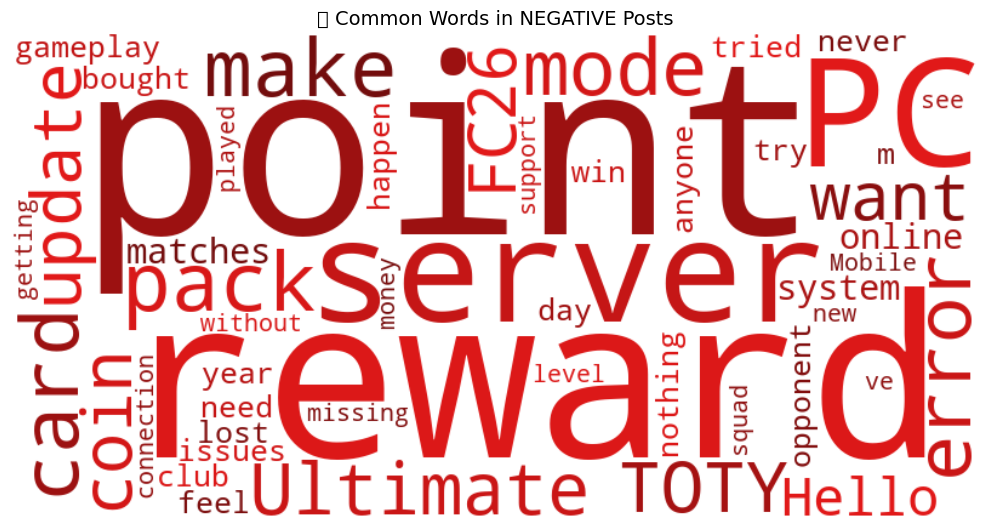

In [31]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

custom_stopwords = STOPWORDS.union({
    'ea', 'game', 'games', 'player', 'players', 'team', 'account',
    'will', 'get', 'got', 'one', 'also', 'would', 'could', 'even',
    'like', 'just', 'now', 'know', 'dont', "don't", 'im', "i'm",
    'issue', 'play', 'fc', 'problem', 'bug', 'match', 'playing', 'time', 's', 'fix', 'still', 'every', 'back', 'Please', 'Thank', 'help'
})

# Custom color function that only uses darker reds
def red_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    # Generate shades from medium red to dark red (avoiding light colors)
    return f"hsl(0, 80%, {np.random.randint(25, 50)}%)"  # Lightness between 25-50%

plt.figure(figsize=(10, 6))

negative_text = ' '.join(df[df['sentiment'] == 'Negative']['full_text'].dropna())
wc_neg = WordCloud(width=800, height=400, background_color='white',
                  stopwords=custom_stopwords,
                  max_words=50,
                  color_func=red_color_func).generate(negative_text)
plt.imshow(wc_neg, interpolation='bilinear')
plt.title('🔴 Common Words in NEGATIVE Posts', fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

In [37]:
import pandas as pd

def analyze_top_posts(csv_path: str = "ea_forum_sentiment_roberta.csv"):
    """Analyze and display top positive and negative posts by comments and views."""
    
    # Load the data
    df = pd.read_csv(csv_path)
    
    # Display settings for pandas
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.width', None)
    
    # Parse timestamps and show date range
    # Note: Timestamps are timezone-naive (no TZ offset in source data, e.g. "2026-01-21T09:30:00")
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    min_date = df['timestamp'].min()
    max_date = df['timestamp'].max()
    
    print("=" * 100)
    print("DATA RANGE")
    print("=" * 100)
    print(f"Earliest post: {min_date.strftime('%Y-%m-%d %H:%M:%S')} (timezone unknown)")
    print(f"Latest post:   {max_date.strftime('%Y-%m-%d %H:%M:%S')} (timezone unknown)")
    print(f"Total posts:   {len(df):,}")
    print()
    
    # Filter negative posts (sentiment == 'Negative')
    negative_df = df[df['sentiment'] == 'Negative'].copy()
    
    # Keywords to search for
    keywords = ["reward", "PC", "server", "Ultimate", "toty", "card", "coin", "points", "pack"]
    
    # Count negative posts for each keyword
    keyword_counts = []
    for keyword in keywords:
        mask = (
            negative_df['title'].str.contains(keyword, case=False, na=False) |
            negative_df['body_preview'].str.contains(keyword, case=False, na=False)
        )
        count = mask.sum()
        keyword_counts.append((keyword, count))
    
    # Sort keywords by count in descending order (most negative posts first)
    keyword_counts.sort(key=lambda x: x[1], reverse=True)
    
    # Print results in sorted order
    for keyword, _ in keyword_counts:
        print_keyword_results(negative_df, keyword)


def print_keyword_results(negative_df: pd.DataFrame, keyword: str):
    """Print top 3 negative posts containing a specific keyword."""
    
    # Case-insensitive search in title and body_preview
    mask = (
        negative_df['title'].str.contains(keyword, case=False, na=False) |
        negative_df['body_preview'].str.contains(keyword, case=False, na=False)
    )
    
    filtered_df = negative_df[mask].copy()
    filtered_df = filtered_df.sort_values(by='comments', ascending=False)
    top_results = filtered_df.head(3)
    
    print("=" * 100)
    print(f"TOP 3 NEGATIVE POSTS CONTAINING \"{keyword}\" (by comments)")
    print(f"Found {len(filtered_df):,} negative posts containing \"{keyword}\"")
    print("=" * 100)
    
    if len(top_results) == 0:
        print("\nNo posts found matching this criteria.\n")
        return
    
    for idx, (_, row) in enumerate(top_results.iterrows(), 1):
        print(f"\n{'─' * 80}")
        print(f"#{idx}")
        print(f"Title:       {row['title']}")
        print(f"Author:      {row['author']}")
        print(f"Category:    {row['category']}")
        print(f"Timestamp:   {row['timestamp'].strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"Score:       {row['compound_score']:.4f}")
        print(f"Confidence:  {row['confidence']:.4f}")
        print(f"Views:       {row['views']:,}")
        print(f"Likes:       {row['likes']:,}")
        print(f"Comments:    {row['comments']:,}")
        print(f"Body:")
        print(f"  {row['body_preview']}")
    
    print("\n\n")


if __name__ == "__main__":
    analyze_top_posts()

DATA RANGE
Earliest post: 2026-01-14 09:45:00 (timezone unknown)
Latest post:   2026-01-21 09:30:00 (timezone unknown)
Total posts:   1,551

TOP 3 NEGATIVE POSTS CONTAINING "toty" (by comments)
Found 151 negative posts containing "toty"

────────────────────────────────────────────────────────────────────────────────
#1
Title:       No xp pro clubs fc26
Author:      ammer9
Category:    FC 26 Bug Reports
Timestamp:   2026-01-21 09:05:00
Score:       -0.7186
Confidence:  0.7186
Views:       412
Likes:       26
Comments:    45
Body:
  I have played more than 10 matches in pro clubs but I am not receiving any XP after completing the games. 
 
 ⚡Highlighted CM response: 
 Hello everyone, 
 Thank you for bringing up this XP issue in Clubs with the TOTY edition. 
 We've passed on the issue to the team so they can investigate.

────────────────────────────────────────────────────────────────────────────────
#2
Title:       Concerns regarding the new TOTY event..
Author:      5qmwwfmsuvsu
Categ

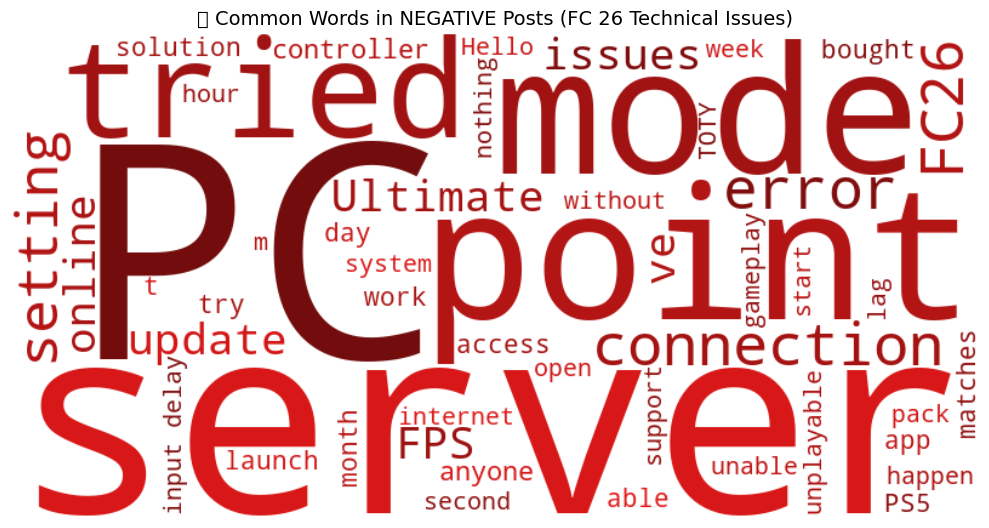

In [5]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

custom_stopwords = STOPWORDS.union({
    'ea', 'game', 'games', 'player', 'players', 'team', 'account',
    'will', 'get', 'got', 'one', 'also', 'would', 'could', 'even',
    'like', 'just', 'now', 'know', 'dont', "don't", 'im', "i'm",
    'issue', 'play', 'fc', 'problem', 'bug', 'match', 'playing', 'time', 's', 'fix', 'still', 'every', 'back', 'Please', 'Thank', 'help'
})

# Custom color function that only uses darker reds
def red_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    # Generate shades from medium red to dark red (avoiding light colors)
    return f"hsl(0, 80%, {np.random.randint(25, 50)}%)"  # Lightness between 25-50%

plt.figure(figsize=(10, 6))

# Filter for FC 26 Technical Issues category AND Negative sentiment
technical_issues_df = df[df['category'] == 'FC 26 Technical Issues']
negative_technical_df = technical_issues_df[technical_issues_df['sentiment'] == 'Negative']

negative_text = ' '.join(negative_technical_df['full_text'].dropna())

wc_neg = WordCloud(width=800, height=400, background_color='white',
                  stopwords=custom_stopwords,
                  max_words=50,
                  color_func=red_color_func).generate(negative_text)
plt.imshow(wc_neg, interpolation='bilinear')
plt.title('🔴 Common Words in NEGATIVE Posts (FC 26 Technical Issues)', fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()


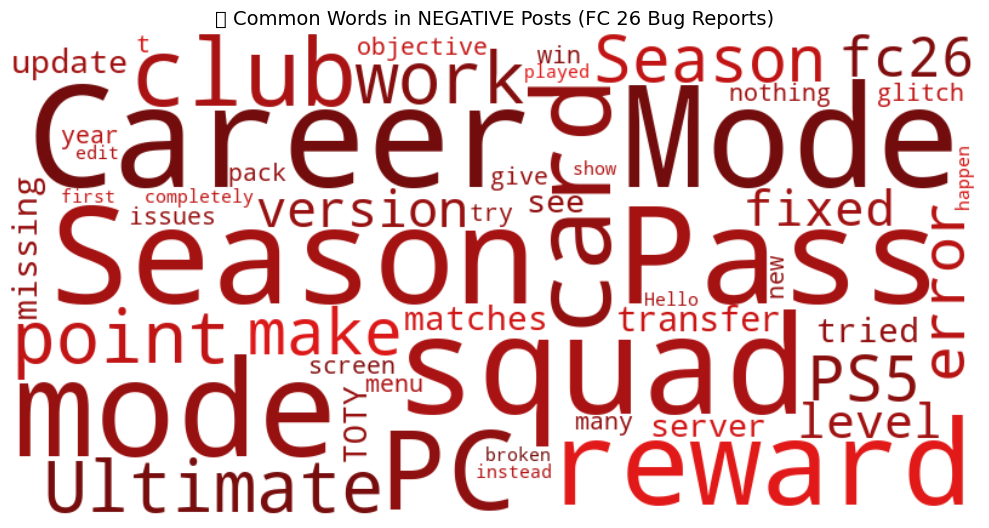

In [6]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

custom_stopwords = STOPWORDS.union({
    'ea', 'game', 'games', 'player', 'players', 'team', 'account',
    'will', 'get', 'got', 'one', 'also', 'would', 'could', 'even',
    'like', 'just', 'now', 'know', 'dont', "don't", 'im', "i'm",
    'issue', 'play', 'fc', 'problem', 'bug', 'match', 'playing', 'time', 's', 'fix', 'still', 'every', 'back', 'Please', 'Thank', 'help'
})

# Custom color function that only uses darker reds
def red_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    # Generate shades from medium red to dark red (avoiding light colors)
    return f"hsl(0, 80%, {np.random.randint(25, 50)}%)"  # Lightness between 25-50%

plt.figure(figsize=(10, 6))

# Filter for FC 26 Technical Issues category AND Negative sentiment
technical_issues_df = df[df['category'] == 'FC 26 Bug Reports']
negative_technical_df = technical_issues_df[technical_issues_df['sentiment'] == 'Negative']

negative_text = ' '.join(negative_technical_df['full_text'].dropna())

wc_neg = WordCloud(width=800, height=400, background_color='white',
                  stopwords=custom_stopwords,
                  max_words=50,
                  color_func=red_color_func).generate(negative_text)
plt.imshow(wc_neg, interpolation='bilinear')
plt.title('🔴 Common Words in NEGATIVE Posts (FC 26 Bug Reports)', fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()


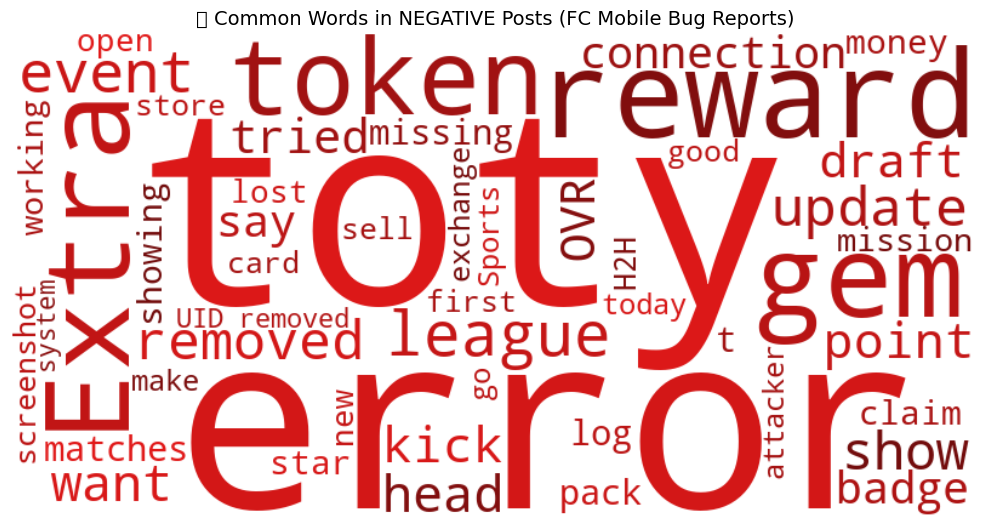

In [7]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

custom_stopwords = STOPWORDS.union({
    'ea', 'game', 'games', 'player', 'players', 'team', 'account',
    'will', 'get', 'got', 'one', 'also', 'would', 'could', 'even',
    'like', 'just', 'now', 'know', 'dont', "don't", 'im', "i'm",
    'issue', 'play', 'fc', 'problem', 'bug', 'match', 'playing', 'time', 's', 'fix', 'still', 'every', 'back', 'Please', 'Thank', 'help', 'mobile', 'Hello'
})

# Custom color function that only uses darker reds
def red_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    # Generate shades from medium red to dark red (avoiding light colors)
    return f"hsl(0, 80%, {np.random.randint(25, 50)}%)"  # Lightness between 25-50%

plt.figure(figsize=(10, 6))

# Filter for FC 26 Technical Issues category AND Negative sentiment
technical_issues_df = df[df['category'] == 'FC Mobile Bug Reports']
negative_technical_df = technical_issues_df[technical_issues_df['sentiment'] == 'Negative']

negative_text = ' '.join(negative_technical_df['full_text'].dropna())

wc_neg = WordCloud(width=800, height=400, background_color='white',
                  stopwords=custom_stopwords,
                  max_words=50,
                  color_func=red_color_func).generate(negative_text)
plt.imshow(wc_neg, interpolation='bilinear')
plt.title('🔴 Common Words in NEGATIVE Posts (FC Mobile Bug Reports)', fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()
